In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Exploratory Data Analysis Part 2: Emissions
#### The largest part of the Albuquerque vehicle emissions check dataset consists of emissions measurements. The test measures:
 - four emissions (CO, HC, CO, O^2)
 - in two runs 
 - at two speeds ("idle" and "high")

#### In this notebook, we explore how these measurements interact among themselves and with the target variable (the future test result). Can we use the emission measurements to predict a future pass or fail?

## Read dataset

#### We use the data subsample (10% of all the data). Let's briefly look at the columns before we discard about half of them.

In [2]:
data_path = '../data/'
df = pd.read_csv(data_path + 'sample.csv', parse_dates=['TEST_SDATE', 'TEST_EDATE'], lineterminator='\n')

In [3]:
len(df.columns)

127

In [4]:
df.columns

Index(['RecordID', 'RECORD_NUM', 'VIR_CERT_NUMBER', 'STATION_NUM',
       'ANALYZER_NUM', 'INSPECTOR_NUM', 'TEST_TYPE', 'VID_TEST_TYPE',
       'TEST_SDATE', 'TEST_EDATE',
       ...
       'E_IDLE_HC_RESULT', 'MECHANIC_LAST_NAME', 'MECHANIC_FIRST_NAME',
       'MECHANIC_MIDDLE_INIT', 'ENGINE_SIZE_ORIG', 'FAILED_IDLE_RPM',
       'SENTTOVID', 'Station_License_Number', 'Analyzer_Number',
       'Insert_DateTime\r'],
      dtype='object', length=127)

#### We can discard those columns that are not related to emissions

In [5]:
slice_col = df.columns[64+4]

In [6]:
em_df = df.loc[:, :slice_col]

#### We add the emission test results and the overall result

In [7]:
em_df['OVERALL_RESULT'] = df.OVERALL_RESULT
em_df['E_HIGH_CO_RESULT'] = df.E_HIGH_CO_RESULT
em_df['E_HIGH_HC_RESULT'] = df.E_HIGH_HC_RESULT
em_df['E_IDLE_CO_RESULT'] = df.E_IDLE_CO_RESULT
em_df['E_IDLE_HC_RESULT'] = df.E_IDLE_HC_RESULT

#### What is the distribution of the result variable?

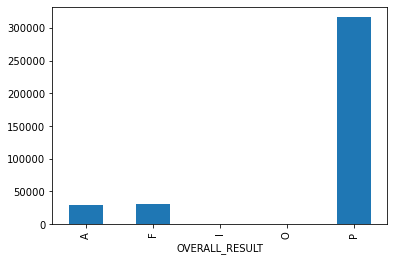

In [8]:
em_df.groupby('OVERALL_RESULT').size().plot.bar()
plt.show()

#### Let's get rid of the "I" and "O" variables as they seem insignificant. It's probably better to get rid of the "A"s (for "Abort") too, but we'll leave them for the moment

In [9]:
em_df = em_df[em_df.OVERALL_RESULT.isin(['A', 'F', 'P'])]

## Target variable
#### Our target variable is the future test result. Therefore: Group the dataframe by vehicle identification number (VIN) and shift the "OVERALL RESULT" column by -1. This reduces our dataset: All those datapoints that do not have a future result will have a NaN target value. We exclude those.

In [10]:
em_df['TARGET'] = em_df.groupby('VIN')['OVERALL_RESULT'].shift(-1)

In [11]:
em_df.sort_values(['VIN', 'TEST_SDATE'])[['VIN', 'TEST_SDATE', 'OVERALL_RESULT', 'TARGET']].tail()

,VIN,TEST_SDATE,OVERALL_RESULT,TARGET
372346,ZHWGU12T36LA03105,2019-11-04 15:34:52,P,NaN
108463,ZHWGU22T58LA06080,2009-09-18 10:29:00,A,P
246038,ZHWGU22T58LA06080,2014-09-05 11:54:00,P,P
297168,ZHWGU22T58LA06080,2016-09-10 09:39:00,P,P
359974,ZHWGU22T58LA06080,2019-05-06 15:49:53,P,NaN


#### What is the percentage of NaNs in TARGET? (These are results of the shift; every test that was not followed by another test has a NaN target)

In [12]:
round(len(em_df[em_df.TARGET.isna()])/len(em_df), 2)

0.35

In [13]:
em_df = em_df[em_df.TARGET.notna()]

#### How is the target variable distributed?

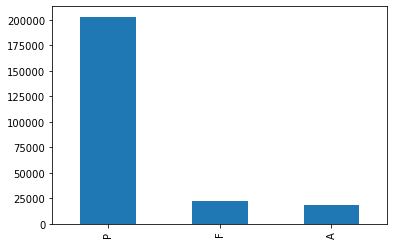

In [14]:
em_df.TARGET.value_counts().plot.bar()
plt.show()

#### The "I" and "O" results seem to be insignificant. Let's get rid of them.

In [15]:
em_df = em_df[em_df.TARGET.isin(['P', 'F', 'A'])]

## Look at columns

### E Result (Summary of the emissions portion of the test)
#### Can we use this variable? --> Unfortunately not, as most of its values are "N", which is neither Pass nor Fail, and is not described in the metadata

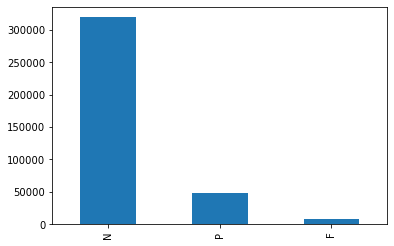

In [40]:
em_df.E_RESULT_STRING.value_counts().plot.bar()
plt.show()

## Emissions

### First test
#### How are the emissions distributed? As the histograms show, they are mostly zero. 

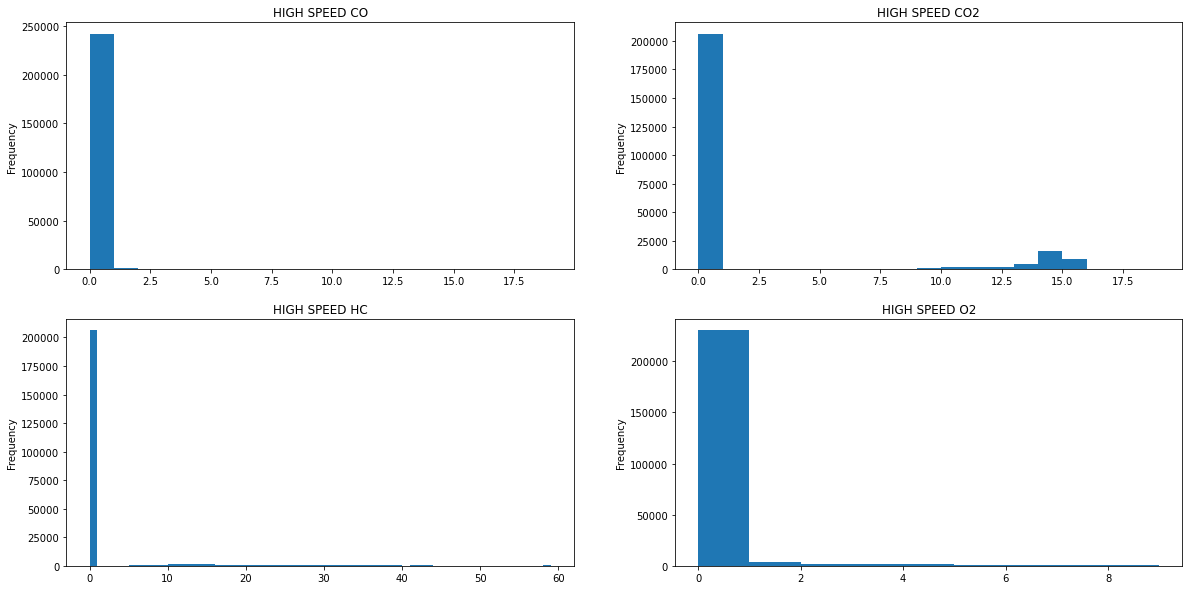

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
em_df.E_HIGH_CO.plot.hist(bins = range(20), ax=axs[0,0], title='HIGH SPEED CO')
em_df.E_HIGH_CO2.plot.hist(bins = range(20), ax=axs[0,1], title='HIGH SPEED CO2')
em_df.E_HIGH_HC.plot.hist(bins = range(60), ax=axs[1,0], title='HIGH SPEED HC')
em_df.E_HIGH_O2.plot.hist(bins = range(10), ax=axs[1,1], title='HIGH SPEED O2')  
plt.show()

### Emissions second test
#### The same is true for the results of the second test.

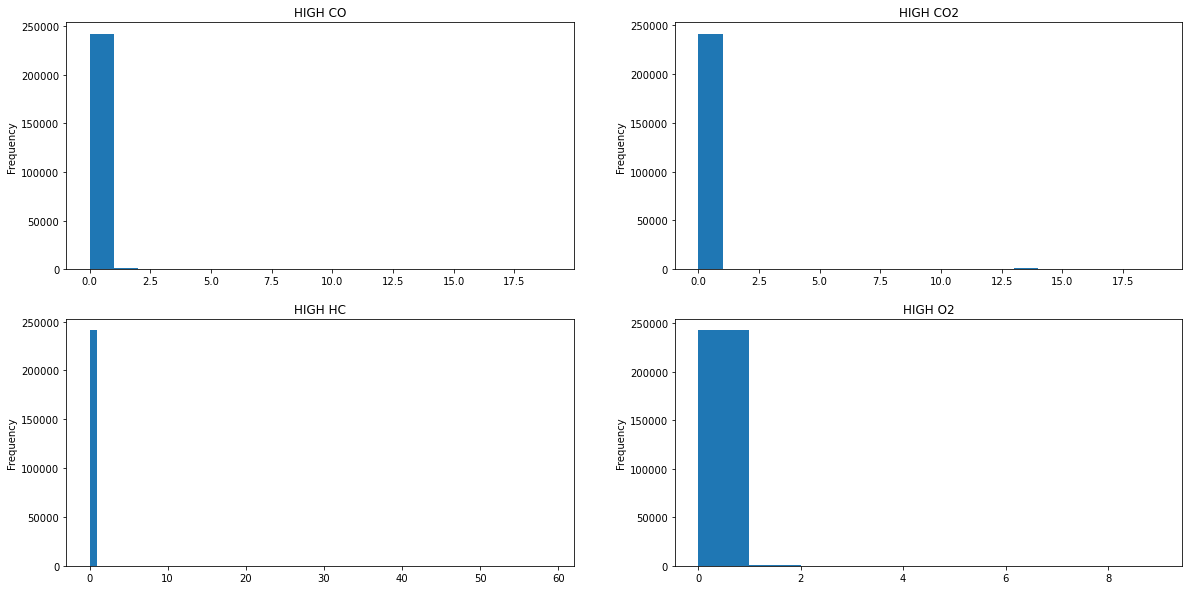

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
em_df.E_HIGH_CO_2.plot.hist(bins = range(20), ax=axs[0,0], title='HIGH CO')
em_df.E_HIGH_CO2_2.plot.hist(bins = range(20), ax=axs[0,1], title='HIGH CO2')
em_df.E_HIGH_HC_2.plot.hist(bins = range(60), ax=axs[1,0], title='HIGH HC')
em_df.E_HIGH_O2_2.plot.hist(bins = range(10), ax=axs[1,1], title='HIGH O2') 
plt.show()

#### These plots don't tell us much. From now on, we will use scatterplots to investigate the interactions among emission results. We color them by the target variable / the overall result. Setting alpha to a very low value allows us to observe trends.

### Emission interactions

### FIRST CHECK; IDLE vs. HIGH

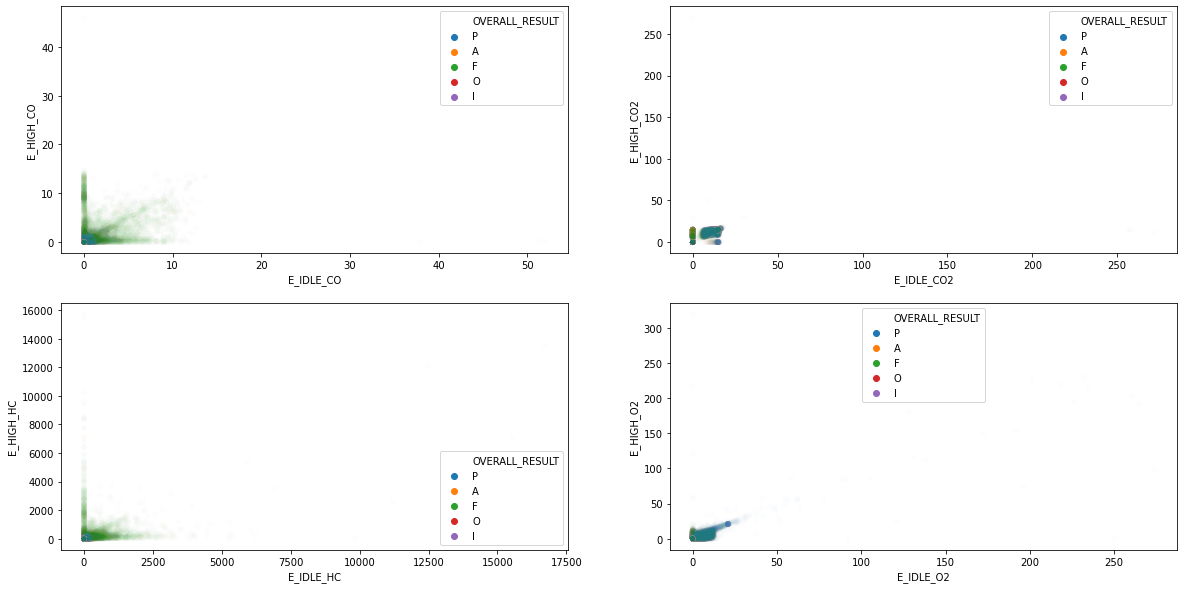

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df, x='E_IDLE_CO', y='E_HIGH_CO', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df, x='E_IDLE_CO2', y='E_HIGH_CO2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df, x='E_IDLE_HC', y='E_HIGH_HC',  hue='OVERALL_RESULT', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df, x='E_IDLE_O2', y='E_HIGH_O2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,1])
plt.show()

#### Lower CO and HC values are better. We can observe a concentration of "Passes" around the origin (where both values are zero). Another peculiar pattern shows that for a lot of vehicles, either the idle OR the high test results are zero, but the other one is not. Does that mean that if one result is higher than zero, the other one doesn't matter (which would mean that those zeros are effectively NaNs)? Or is it the other way round?

#### Let's try plotting this again, this time with solid colors (alpha=1)

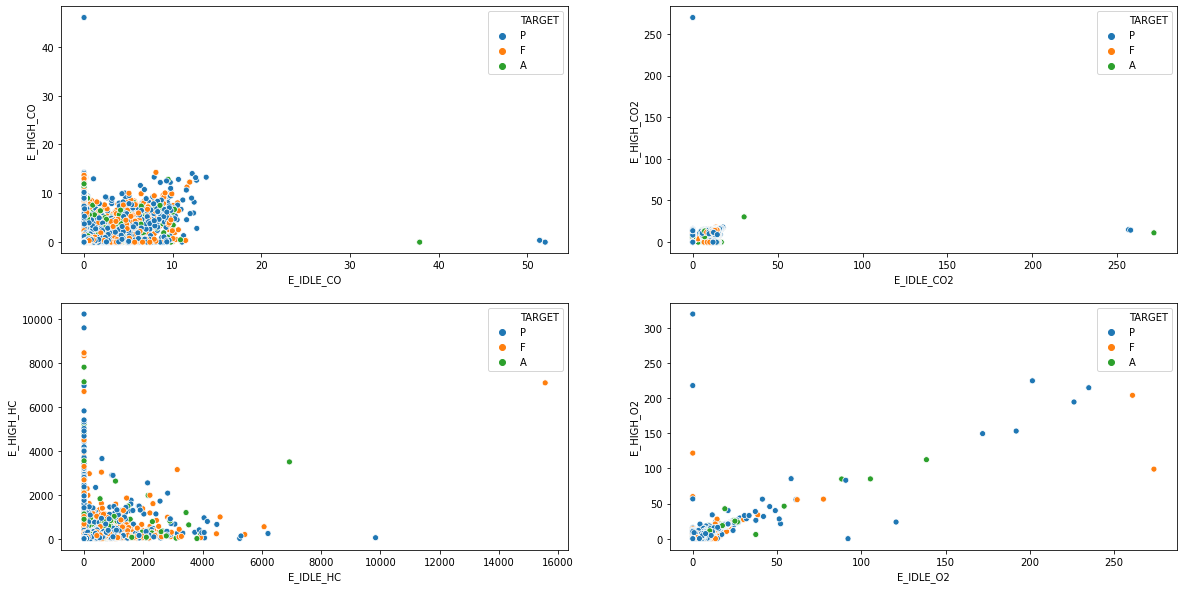

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df, x='E_IDLE_CO', y='E_HIGH_CO', hue='TARGET', alpha=1, ax=axs[0,0])
sns.scatterplot(data=em_df, x='E_IDLE_CO2', y='E_HIGH_CO2', hue='TARGET', alpha=1, ax=axs[0,1])
sns.scatterplot(data=em_df, x='E_IDLE_HC', y='E_HIGH_HC',  hue='TARGET', alpha=1, ax=axs[1,0])
sns.scatterplot(data=em_df, x='E_IDLE_O2', y='E_HIGH_O2', hue='TARGET', alpha=1, ax=axs[1,1])
plt.show()

#### Does the test sequence (whether the high or the idle speed are tested first) influence the emission values?

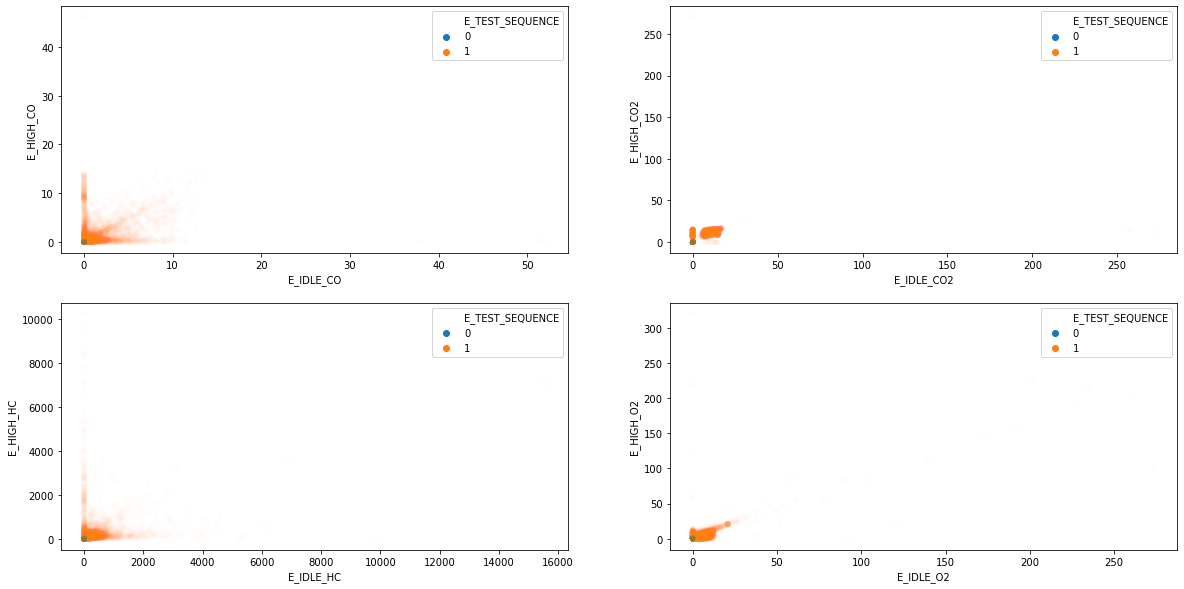

In [18]:
# color by test sequence

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df[em_df.E_TEST_SEQUENCE.isin([0,1])], x='E_IDLE_CO', y='E_HIGH_CO', hue='E_TEST_SEQUENCE', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df[em_df.E_TEST_SEQUENCE.isin([0,1])], x='E_IDLE_CO2', y='E_HIGH_CO2', hue='E_TEST_SEQUENCE', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df[em_df.E_TEST_SEQUENCE.isin([0,1])], x='E_IDLE_HC', y='E_HIGH_HC',  hue='E_TEST_SEQUENCE', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df[em_df.E_TEST_SEQUENCE.isin([0,1])], x='E_IDLE_O2', y='E_HIGH_O2', hue='E_TEST_SEQUENCE', alpha=.01, ax=axs[1,1])
plt.show()

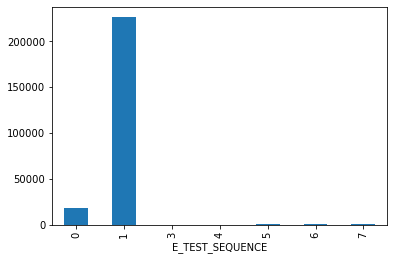

In [19]:
em_df.groupby('E_TEST_SEQUENCE').size().plot.bar()
plt.show()

### SECOND CHECK; IDLE vs. HIGH

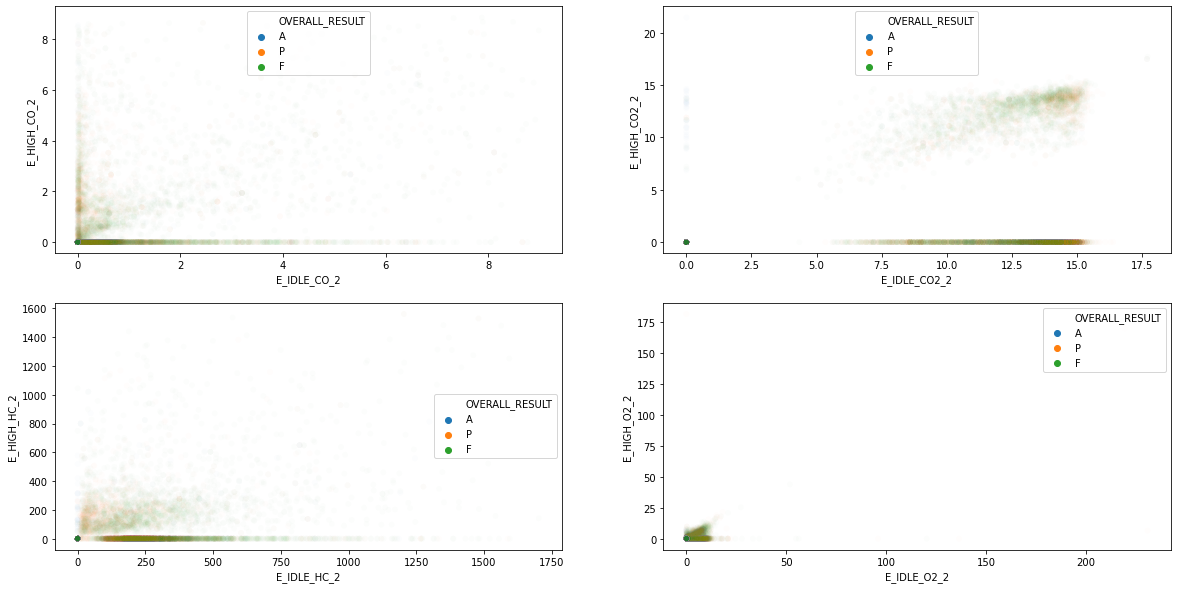

In [20]:
# IDLE vs HIGH speed, second round

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df, x='E_IDLE_CO_2', y='E_HIGH_CO_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df, x='E_IDLE_CO2_2', y='E_HIGH_CO2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df, x='E_IDLE_HC_2', y='E_HIGH_HC_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df, x='E_IDLE_O2_2', y='E_HIGH_O2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,1])
plt.legend(loc='upper right')
plt.show()

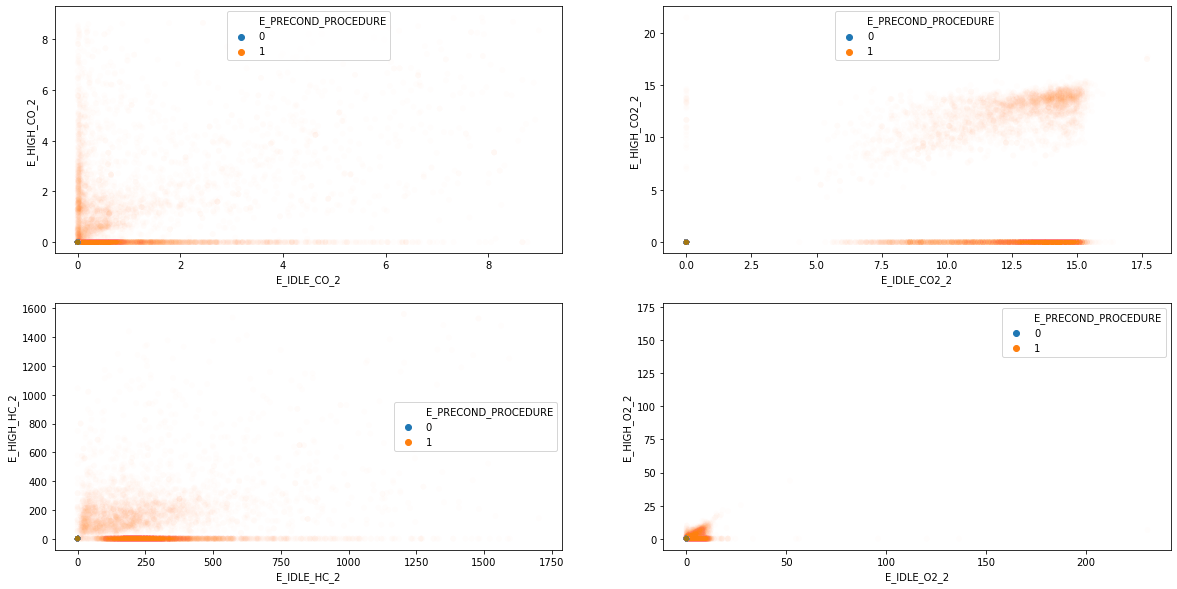

In [21]:
# IDLE vs HIGH speed, second round

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df[em_df.E_PRECOND_PROCEDURE.isin([0,1])], x='E_IDLE_CO_2', y='E_HIGH_CO_2', hue='E_PRECOND_PROCEDURE', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df[em_df.E_PRECOND_PROCEDURE.isin([0,1])], x='E_IDLE_CO2_2', y='E_HIGH_CO2_2', hue='E_PRECOND_PROCEDURE', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df[em_df.E_PRECOND_PROCEDURE.isin([0,1])], x='E_IDLE_HC_2', y='E_HIGH_HC_2', hue='E_PRECOND_PROCEDURE', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df[em_df.E_PRECOND_PROCEDURE.isin([0,1])], x='E_IDLE_O2_2', y='E_HIGH_O2_2', hue='E_PRECOND_PROCEDURE', alpha=.01, ax=axs[1,1])
plt.legend(loc='upper right')
plt.show()

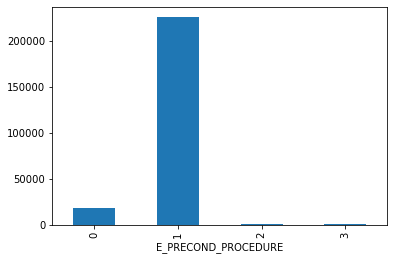

In [22]:
em_df.groupby('E_PRECOND_PROCEDURE').size().plot.bar()
plt.show()

### FIRST CHECK; HC vs. CO

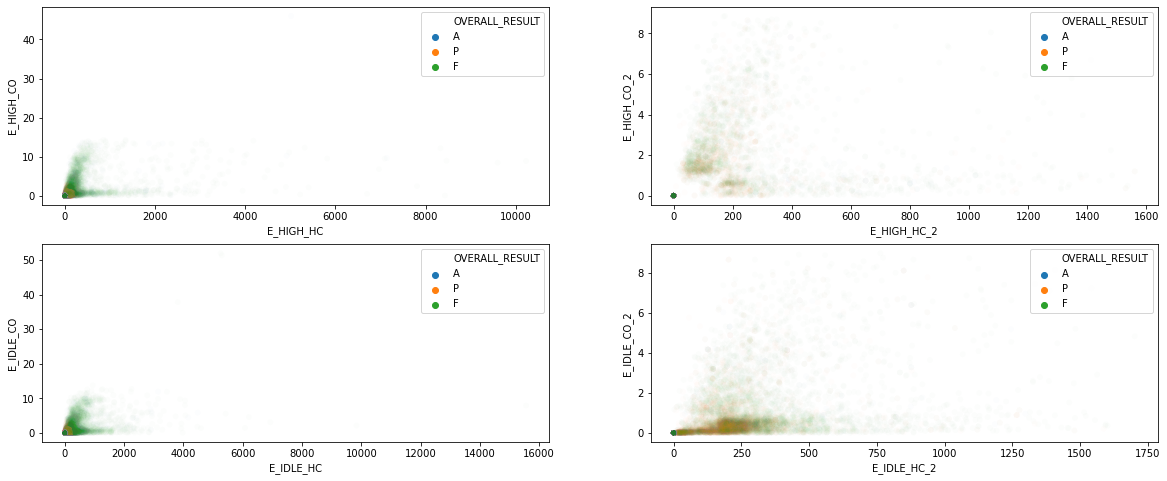

In [23]:
# negative relationship CO2 and CO

fig, axs = plt.subplots(2, 2, figsize=(20,8))
sns.scatterplot(data=em_df, x='E_HIGH_HC', y='E_HIGH_CO', hue='OVERALL_RESULT', alpha=0.01, ax=axs[0, 0])
sns.scatterplot(data=em_df, x='E_HIGH_HC_2', y='E_HIGH_CO_2', hue='OVERALL_RESULT', alpha=0.01, ax=axs[0, 1])
sns.scatterplot(data=em_df, x='E_IDLE_HC', y='E_IDLE_CO', hue='OVERALL_RESULT', alpha=0.01, ax=axs[1, 0])
sns.scatterplot(data=em_df, x='E_IDLE_HC_2', y='E_IDLE_CO_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1, 1])
plt.legend(loc='upper right')
plt.show()

### IS CO2 LOWER FOR FAILED CARS ?

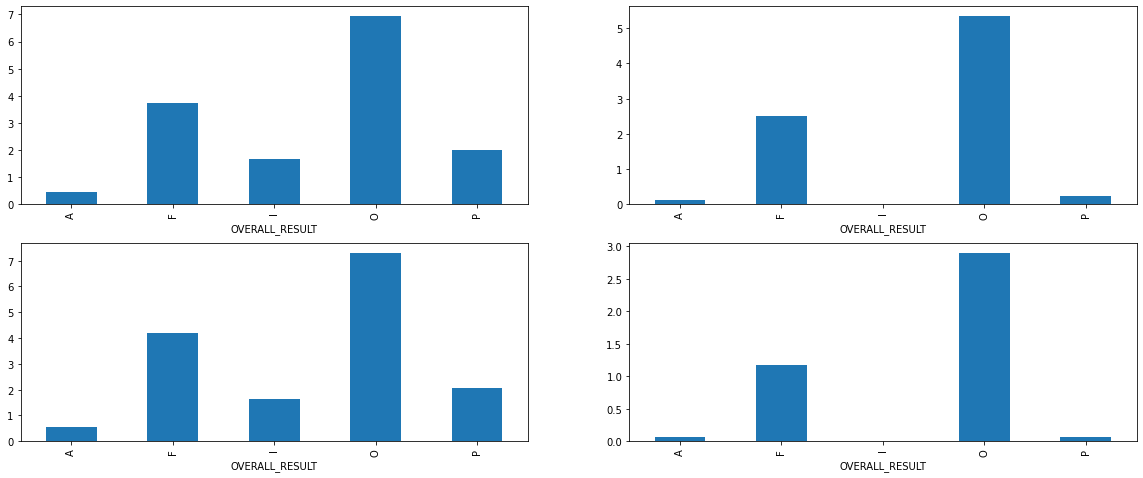

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
em_df.groupby('OVERALL_RESULT').E_IDLE_CO2.mean().plot.bar(ax=axs[0,0])
em_df.groupby('OVERALL_RESULT').E_IDLE_CO2_2.mean().plot.bar(ax=axs[0,1])
em_df.groupby('OVERALL_RESULT').E_HIGH_CO2.mean().plot.bar(ax=axs[1,0])
em_df.groupby('OVERALL_RESULT').E_HIGH_CO2_2.mean().plot.bar(ax=axs[1,1])
plt.show()

### AVG HC FAIL AND PASS

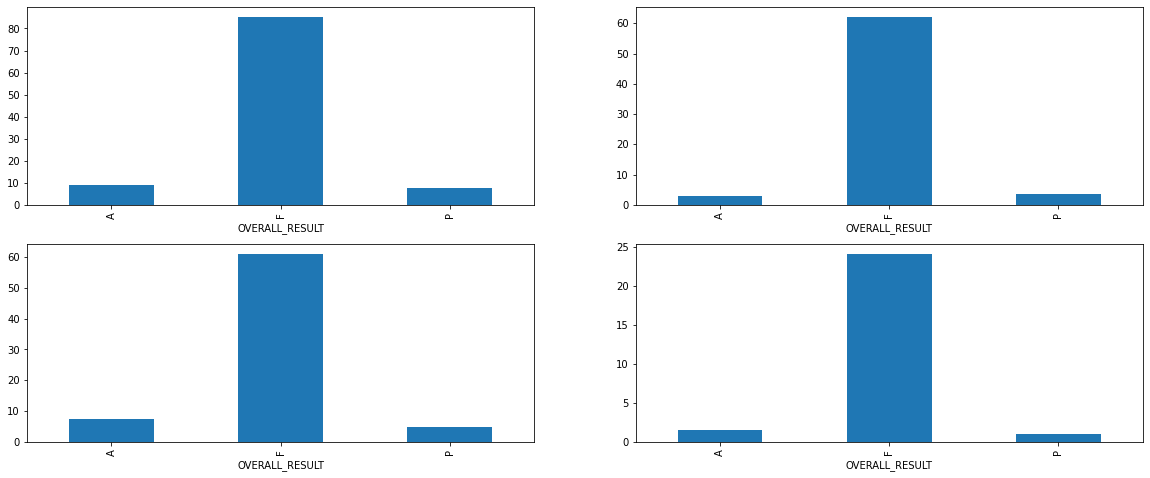

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
em_df.groupby('OVERALL_RESULT').E_IDLE_HC.mean().plot.bar(ax=axs[0,0])
em_df.groupby('OVERALL_RESULT').E_IDLE_HC_2.mean().plot.bar(ax=axs[0,1])
em_df.groupby('OVERALL_RESULT').E_HIGH_HC.mean().plot.bar(ax=axs[1,0])
em_df.groupby('OVERALL_RESULT').E_HIGH_HC_2.mean().plot.bar(ax=axs[1,1])
plt.show()

### IDLE SPEED; 1st vs. 2nd ROUND

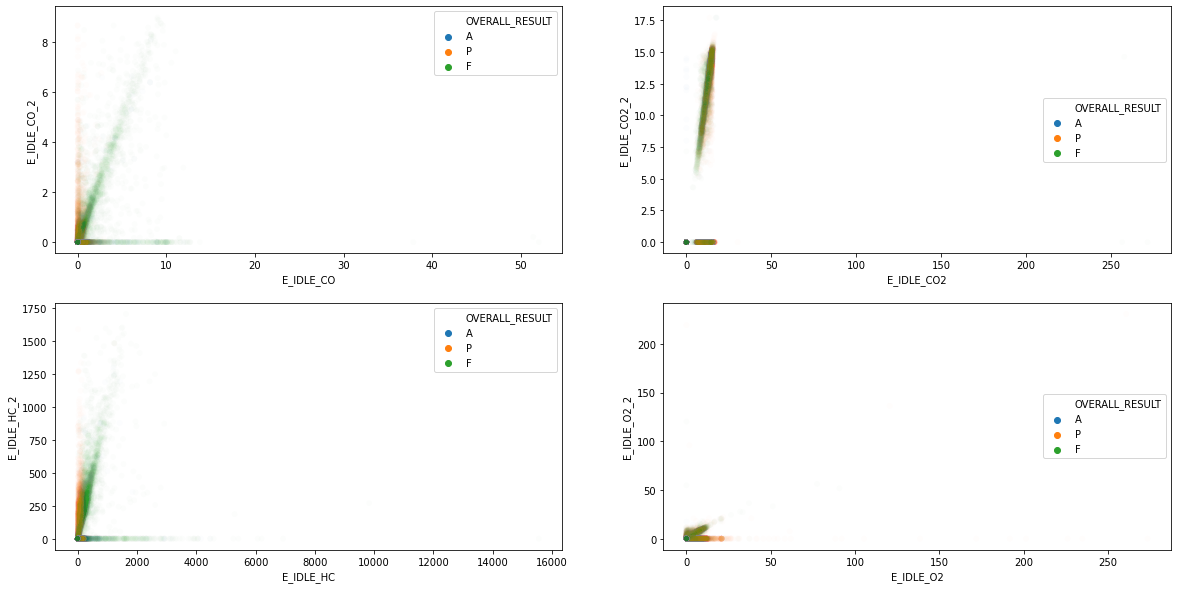

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df, x='E_IDLE_CO', y='E_IDLE_CO_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df, x='E_IDLE_CO2', y='E_IDLE_CO2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df, x='E_IDLE_HC', y='E_IDLE_HC_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df, x='E_IDLE_O2', y='E_IDLE_O2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,1])
plt.show()

### HIGH SPEED; 1st vs. 2nd ROUND

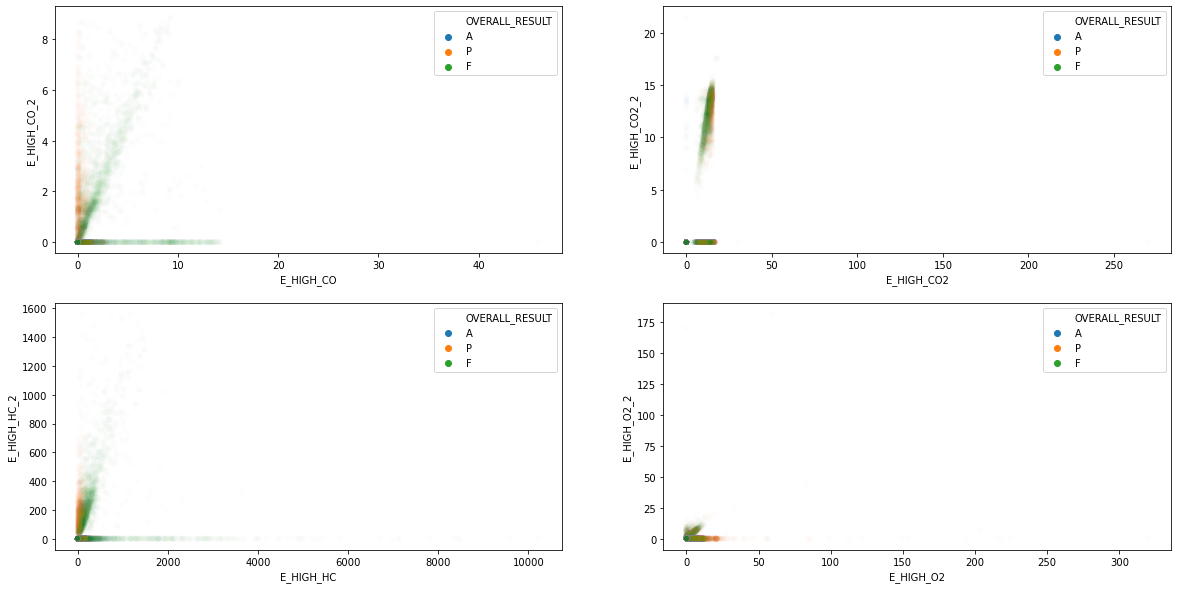

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.scatterplot(data=em_df, x='E_HIGH_CO', y='E_HIGH_CO_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,0])
sns.scatterplot(data=em_df, x='E_HIGH_CO2', y='E_HIGH_CO2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[0,1])
sns.scatterplot(data=em_df, x='E_HIGH_HC', y='E_HIGH_HC_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,0])
sns.scatterplot(data=em_df, x='E_HIGH_O2', y='E_HIGH_O2_2', hue='OVERALL_RESULT', alpha=.01, ax=axs[1,1])
plt.show()

### MODEL YEAR & EMISSIONS
#### Are model year and high emission values correlated?

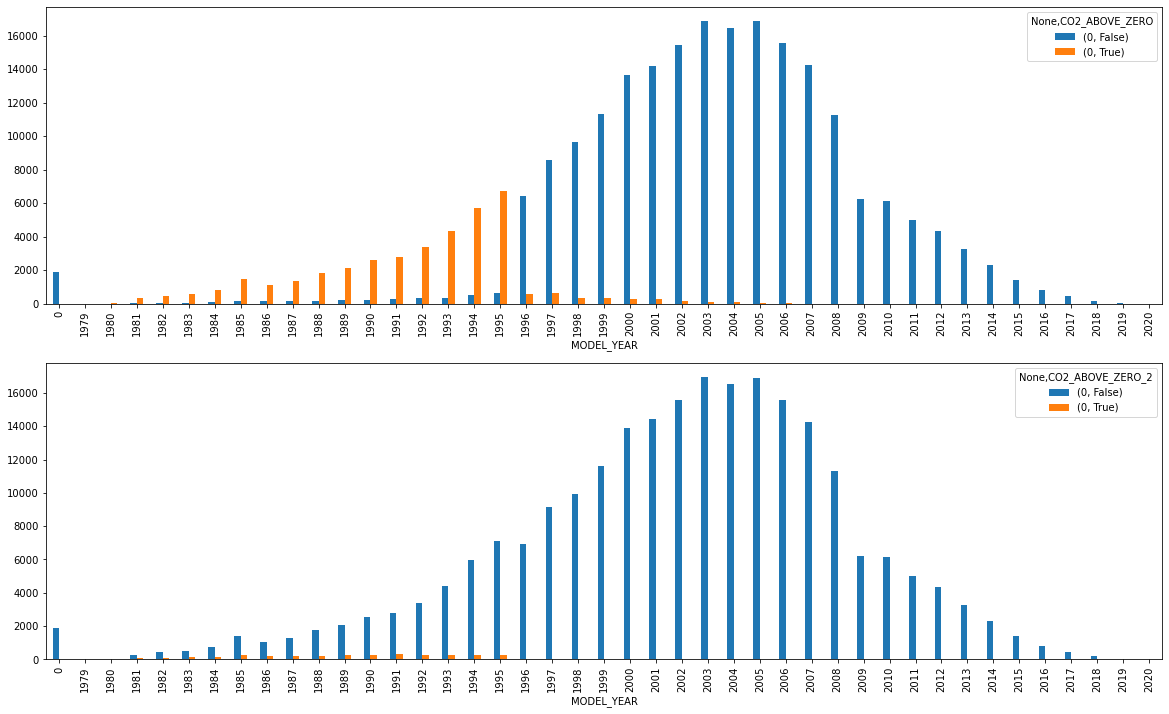

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['CO2_ABOVE_ZERO'] = em_df.E_HIGH_CO2 > 0
em_df['CO2_ABOVE_ZERO_2'] = em_df.E_HIGH_CO2_2 > 0
em_df['CO2_ABOVE_ZERO_IDLE'] = em_df.E_IDLE_CO2 > 0
em_df['CO2_ABOVE_ZERO_IDLE_2'] = em_df.E_IDLE_CO2_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO2_ABOVE_ZERO']).size()).unstack().fillna(0).plot.bar(ax=ax[0])
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO2_ABOVE_ZERO_2']).size()).unstack().fillna(0).plot.bar(ax=ax[1])
plt.show()

### MODEL YEAR & EMISSIONS NORMALIZED

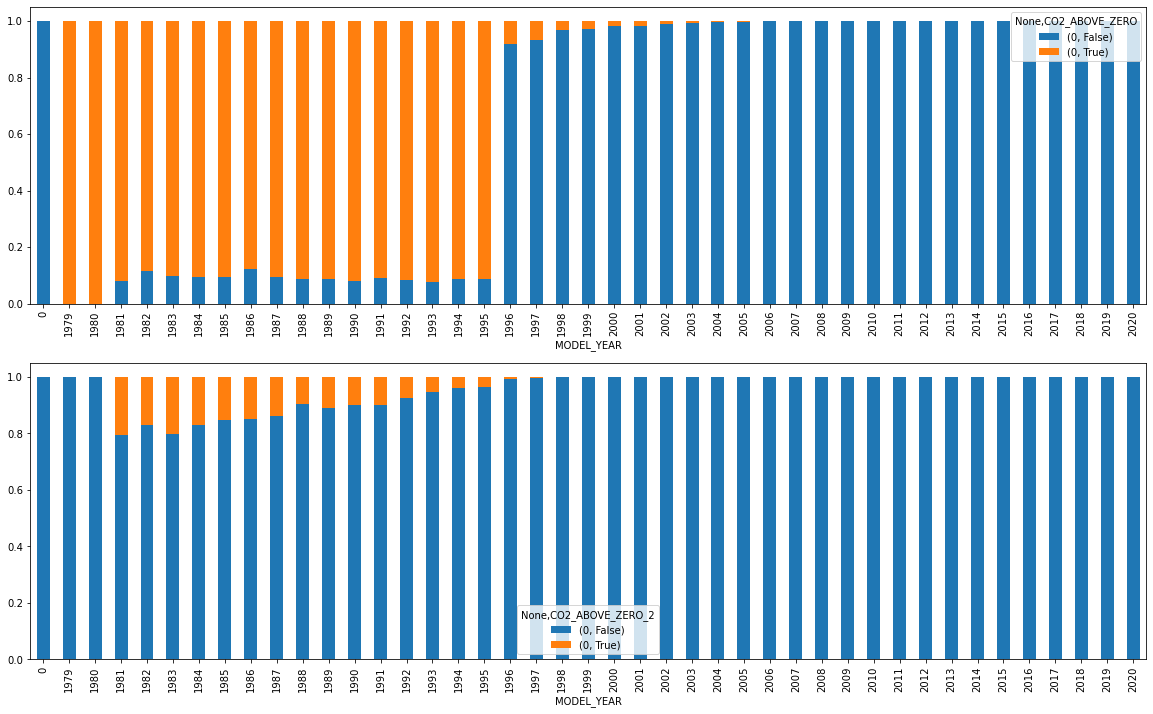

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['CO2_ABOVE_ZERO'] = em_df.E_HIGH_CO2 > 0
em_df['CO2_ABOVE_ZERO_2'] = em_df.E_HIGH_CO2_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO2_ABOVE_ZERO']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[0], stacked=True)
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO2_ABOVE_ZERO_2']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[1], stacked=True)
plt.show()

### MODEL YEAR & HC

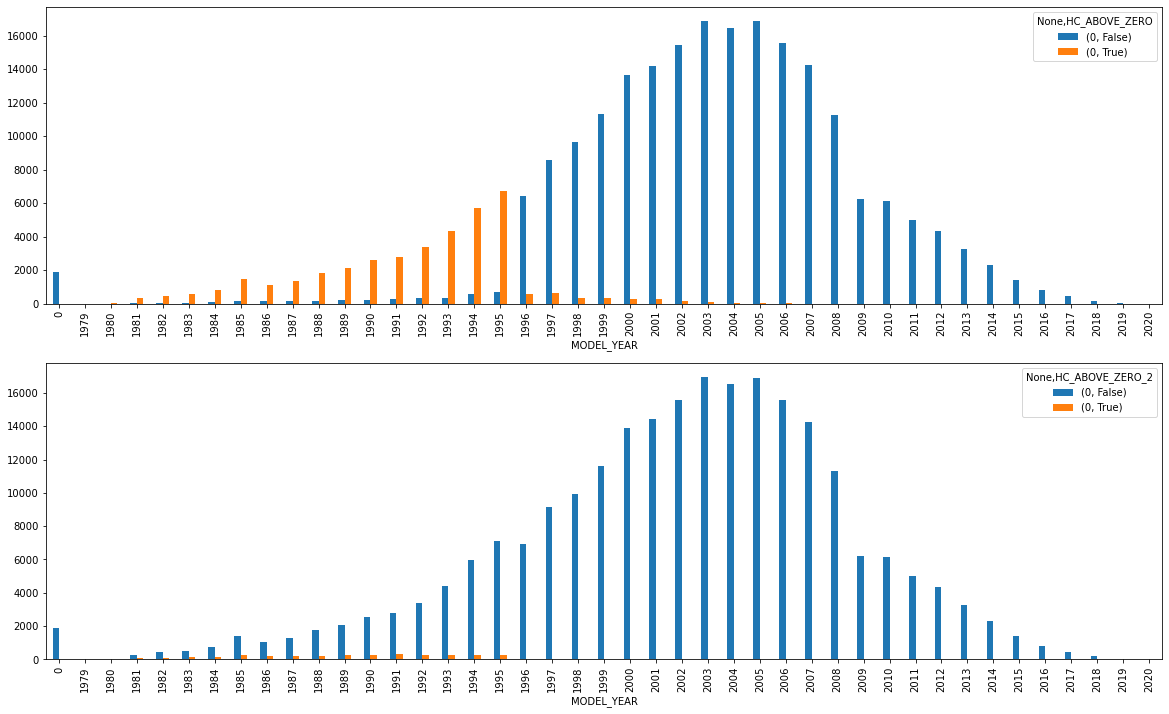

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['HC_ABOVE_ZERO'] = em_df.E_HIGH_HC > 0
em_df['HC_ABOVE_ZERO_2'] = em_df.E_HIGH_HC_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','HC_ABOVE_ZERO']).size()).unstack().fillna(0).plot.bar(ax=ax[0])
pd.DataFrame(em_df.groupby(['MODEL_YEAR','HC_ABOVE_ZERO_2']).size()).unstack().fillna(0).plot.bar(ax=ax[1])
plt.show()

### MODEL YEAR & HC NORMALIZED

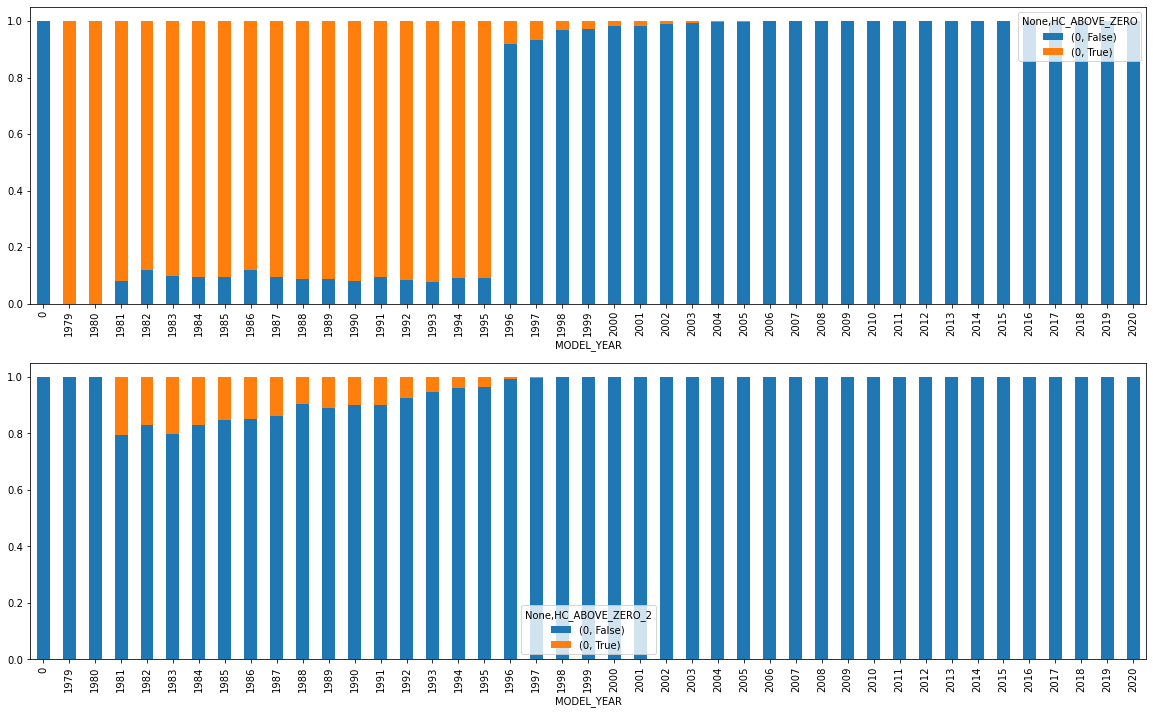

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['HC_ABOVE_ZERO'] = em_df.E_HIGH_HC > 0
em_df['HC_ABOVE_ZERO_2'] = em_df.E_HIGH_HC_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','HC_ABOVE_ZERO']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[0], stacked=True)
pd.DataFrame(em_df.groupby(['MODEL_YEAR','HC_ABOVE_ZERO_2']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[1], stacked=True)
plt.show()

### MODEL YEAR & CO

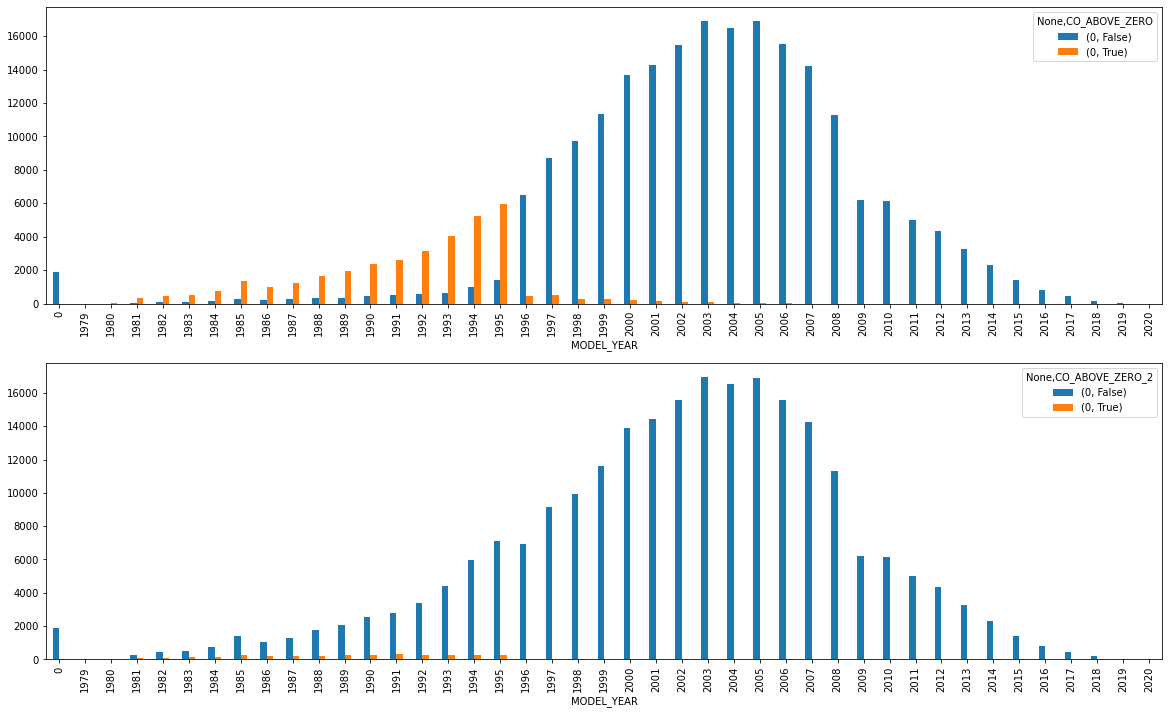

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['CO_ABOVE_ZERO'] = em_df.E_HIGH_CO > 0
em_df['CO_ABOVE_ZERO_2'] = em_df.E_HIGH_CO_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO_ABOVE_ZERO']).size()).unstack().fillna(0).plot.bar(ax=ax[0])
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO_ABOVE_ZERO_2']).size()).unstack().fillna(0).plot.bar(ax=ax[1])
plt.show()

### MODEL YEAR & CO NORMALIZED

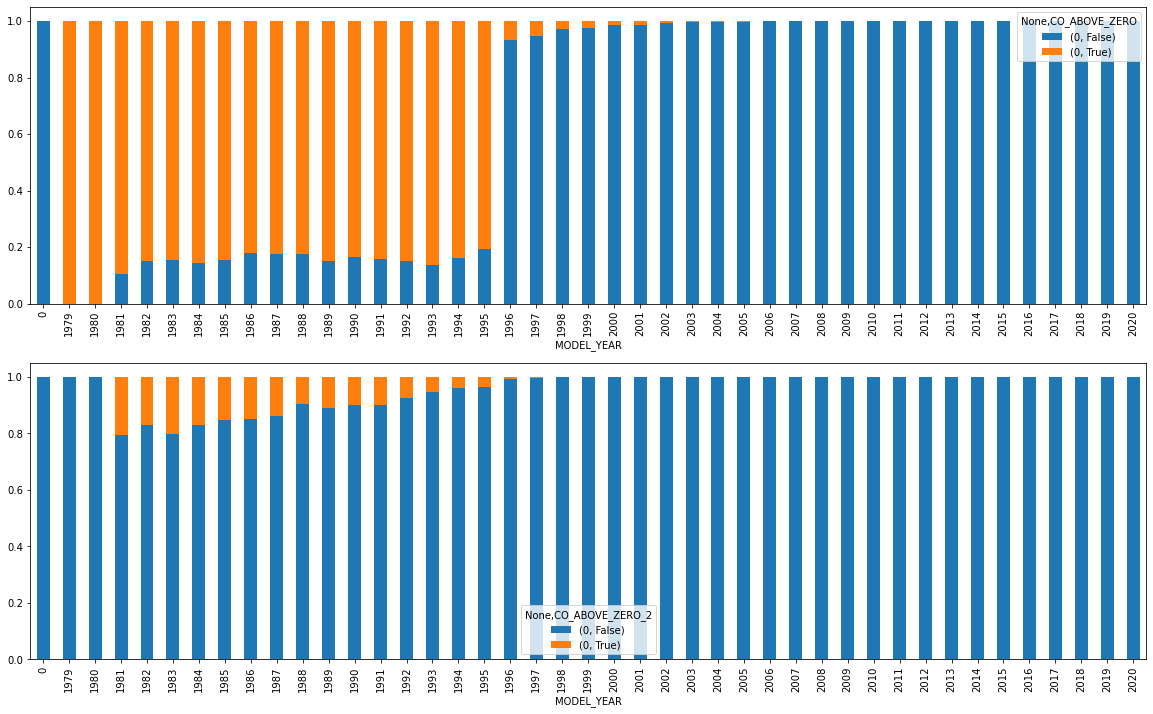

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
em_df['CO_ABOVE_ZERO'] = em_df.E_HIGH_CO > 0
em_df['CO_ABOVE_ZERO_2'] = em_df.E_HIGH_CO_2 > 0
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO_ABOVE_ZERO']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[0], stacked=True)
pd.DataFrame(em_df.groupby(['MODEL_YEAR','CO_ABOVE_ZERO_2']).size()/em_df.groupby('MODEL_YEAR').size()).unstack().fillna(0).plot.bar(ax=ax[1], stacked=True)
plt.show()

In [ ]:
#### High emission values occur only before a certain year. However, even very new vehicles can fail the test. This means 

### MODEL YEAR & TEST RESULT

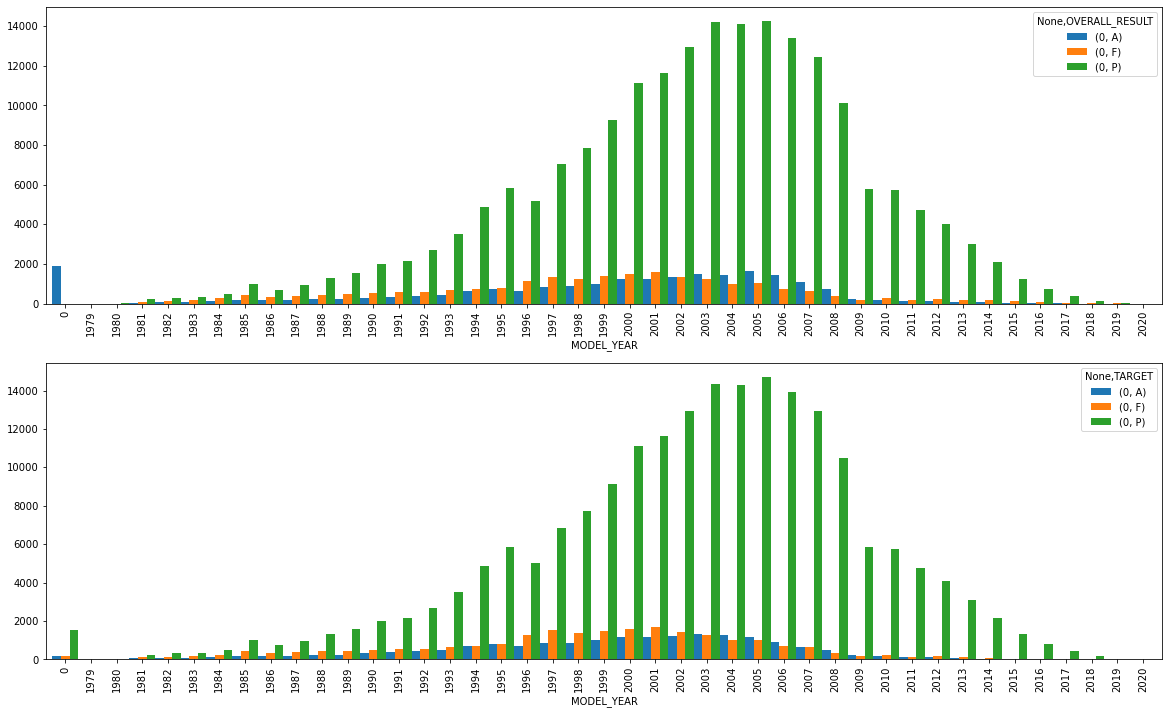

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
pd.DataFrame(em_df.groupby(['MODEL_YEAR','OVERALL_RESULT']).size()).unstack().fillna(0).plot.bar(ax=ax[0], width=1)
pd.DataFrame(em_df.groupby(['MODEL_YEAR','TARGET']).size()).unstack().fillna(0).plot.bar(ax=ax[1], width=1)
plt.show()